# House Prices (Python)

## Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

**Author:** Lingsong Zeng<br>
**Date:** 12/31/2024

## Table of Contents

1. [Introduction](#Introduction)
2. [Data](#Data)
3. [EDA](#EDA)
4. [Feature Engineering](#Feature-Engineering)
5. [Preprocessing](#Preprocessing)
6. [Modeling](#Modeling)   
    - [kNN](#kNN)
    - [SVM](#SVM)
    - [Linear Regression](#Linear-Regression)
    - [Lasso](#Lasso)
    - [Ridge](#Ridge)
    - [ElasticNet](#ElasticNet)
    - [Decision Tree](#Decision-Tree)
    - [Bagging](#Bagging)
    - [Random Forest](#Random-Forest)
    - [XGBoost](#XGBoost)
    - [LightGBM](#LightGBM)
    - [Stacking](#Stacking)
7. [References](#References)

## Introduction

### Overview

> This competition runs indefinitely with a rolling leaderboard. [Learn more](https://www.kaggle.com/docs/competitions#getting-started)

### Description

![](https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Practice Skills

- Creative feature engineering 
- Advanced regression techniques like random forest and gradient boosting

### Acknowledgments

The [Ames Housing dataset](https://www.amstat.org/publications/jse/v19n3/decock.pdf) was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

Photo by [Tom Thain](https://unsplash.com/@tthfilms) on Unsplash.

### Evaluation

#### Goal

It is my job to predict the sales price for each house. For each Id in the test set, predict the value of the `SalePrice` variable. 

#### Metric

Submissions are evaluated on [Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root_mean_square_deviation) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor

## Data

### File descriptions

- `train.csv` - the training set
- `test.csv` - the test set
- `data_description.txt` - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- `sample_submission.csv` - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [2]:
# Define paths for train and test datasets
train_path = os.path.join('data', 'house-prices', 'raw', 'train.csv')
test_path = os.path.join('data', 'house-prices', 'raw', 'test.csv')

# Load datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

Here we using `os.path.join` , the dynamic path generation, instead of using hard-coded paths is aiming to provide better compatibility across different platforms.

Different operating systems use different path separators (e.g. Windows uses `\`, while Linux and macOS use `/`). `os.path.join` automatically chooses the correct separator based on the operating system.

In [3]:
# Basic dataset overview
print("Train dataset shape:", train.shape)
print("Test  dataset shape:", test.shape)

Train dataset shape: (1460, 81)
Test  dataset shape: (1459, 80)


The size of the training dataset and the test dataset are roughly the same. The test dataset has one less column than the training dataset, which is our target column `SalePrice`.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
categorical_features = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
    'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
    'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond'
]

numerical_features = [
    'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
    'MiscVal', 'MoSold', 'YrSold'
]

For `categorical_features` and `numerical_features`, the reason we cannot directly select features with values of `int64` or `float64`, because some features such as `MSSubClass`:

```plaintext
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
```

Its value is `int64` format, but it is actually a categorical feature. Therefore, here I manually distinguish all `categorical_features` and `numerical_features` according to the description in `data_description.txt`.

In [6]:
none_features = {
    'Alley': 'NoAlley',
    'BsmtQual': 'NoBsmt',
    'BsmtCond': 'NoBsmt',
    'BsmtExposure': 'NoBsmt',
    'BsmtFinType1': 'NoBsmt',
    'BsmtFinType2': 'NoBsmt',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'PoolQC': 'NoPool',
    'Fence': 'NoFence',
    'MiscFeature': 'NoFeature'
}

According to the description in `data_description.txt`, `NA` in some features does not mean Missing Value, but means that the observation does not have the feature, such as `Alley`:

```plaintext
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
```

Therefore, the missing value filling treatment of these features should be different. I filtered out all similar features here to prepare for the missing value filling in the subsequent preprocessing.

In [7]:
for feature, value in none_features.items():
    train[feature] = train[feature].fillna(value)
    test[feature] = test[feature].fillna(value)

In [8]:
ordinal_features = [
    "MSSubClass", "OverallQual", "OverallCond", "LotShape", "LandSlope",
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure",
    "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual",
    "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond",
    "PavedDrive", "PoolQC", "Fence"
]

nominal_features = [
    "MSZoning", "Street", "Alley", "LandContour", "Utilities", "LotConfig",
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
    "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
    "Foundation", "Heating", "CentralAir", "Electrical", "GarageType",
    "MiscFeature", "SaleType", "SaleCondition"
]

Similarly, I also distinguish between `ordinal_features` and `nominal_features` here to facilitate subsequent preprocessing. The main difference between them is whether the variable values are ordered. The following are examples of an ordinal feature and a nominal feature respectively.

```plaintext
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
```

In the following preprocessing, ordinal features will be applied with Label Encoding, while nominal features will be applied with One-Hot Encoding.

## EDA

In [9]:
# Summary statistics for SalePrice
print(train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


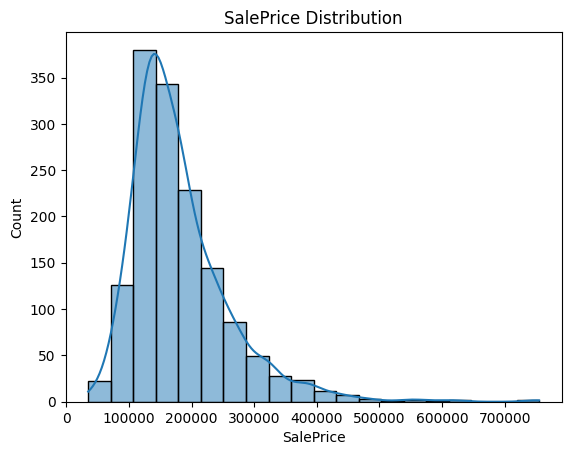

Skewness of SalePrice: 1.8828757597682129
Kurtosis of SalePrice: 6.536281860064529


In [10]:
# Plot the distribution of SalePrice
sns.histplot(train['SalePrice'], bins=20, kde=True)
plt.title('SalePrice Distribution')
plt.show()

# Check skewness and kurtosis of SalePrice
print("Skewness of SalePrice:", train['SalePrice'].skew())
print("Kurtosis of SalePrice:", train['SalePrice'].kurt())

From the histogram and the calculated value of skewness (1.88), we can see that the distribution of `SalePrice` is right-skewed. This may have a negative impact on the training of the model. So we need a log transformation for `SalePrice`.

In [11]:
train['LogSalePrice'] = np.log1p(train['SalePrice'])

We use `np.log1p()` instead of `np.log()` to handle zero values, since `log(0)` does not exist. `np.log1p()` is a shorthand for `log(x+1)` and ensures that the target value is non-negative.

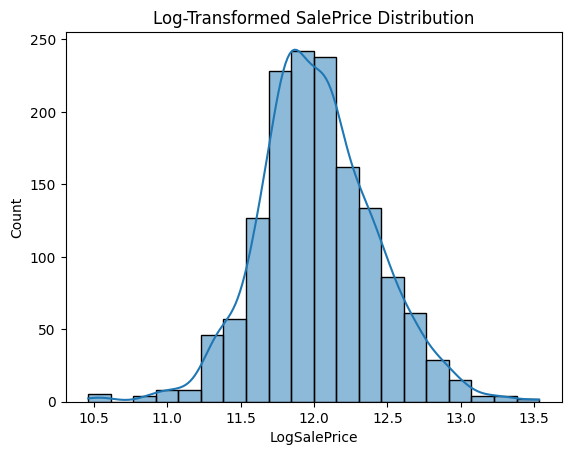

Skewness of (Log-Transformed) SalePrice: 0.12134661989685333
Kurtosis of (Log-Transformed) SalePrice: 0.809519155707878


In [12]:
sns.histplot(train['LogSalePrice'], bins=20, kde=True)
plt.title("Log-Transformed SalePrice Distribution")
plt.show()

print("Skewness of (Log-Transformed) SalePrice:", train['LogSalePrice'].skew())
print("Kurtosis of (Log-Transformed) SalePrice:", train['LogSalePrice'].kurt())

From the charts and statistics, we can see that after logarithmic transformation, the distribution of `SalePrice` is closer to normal distribution.

The following is the distribution of the remaining numerical features:

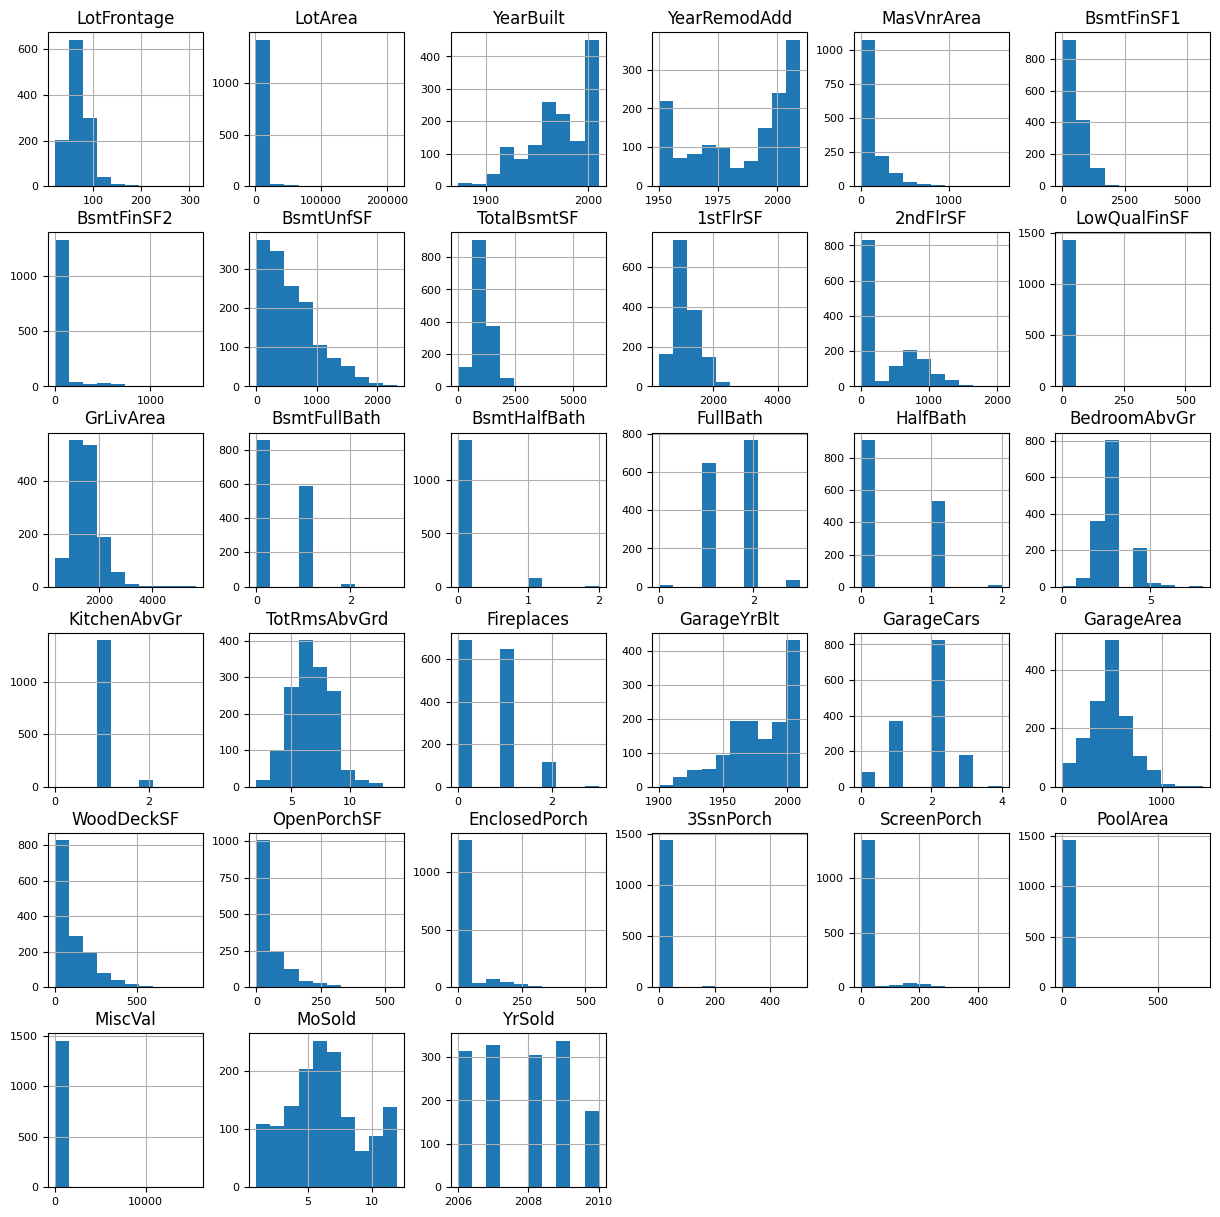

In [13]:
train[numerical_features].hist(figsize=(15, 15), bins=10, xlabelsize=8, ylabelsize=8);

## Feature Engineering

In [14]:
def add_features(data, create_interactions=True, create_base_features=True):
    """
    Add new features to the dataset.
    
    Parameters:
    - data: DataFrame, the input data.
    - create_interactions: bool, whether to create interaction and polynomial features.
    - create_base_features: bool, whether to create base features like `HouseAge`.
    
    Returns:
    - DataFrame with new features added.
    """
    # Create a DataFrame to store new features
    new_features = pd.DataFrame(index=data.index)
    
    # Base features
    if create_base_features:
        new_features['HouseAge'] = data['YrSold'] - data['YearBuilt']
        new_features['RemodelAge'] = data['YrSold'] - data['YearRemodAdd']
        new_features['TotalSF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']
    
    # Interaction and polynomial features
    if create_interactions:
        new_features['GrLivArea_OverallQual'] = data['GrLivArea'] * data['OverallQual']
        new_features['GrLivArea^2'] = data['GrLivArea'] ** 2
        new_features['OverallQual^2'] = data['OverallQual'] ** 2
    
    # Add the new features to the original dataset
    data = pd.concat([data, new_features], axis=1)
    return data

In [15]:
train = add_features(train)
test = add_features(test)

In [16]:
new_features = [
    'HouseAge', 'RemodelAge', 'TotalSF', 
    'GrLivArea_OverallQual', 'GrLivArea^2', 'OverallQual^2'
]
numerical_features.extend(new_features)

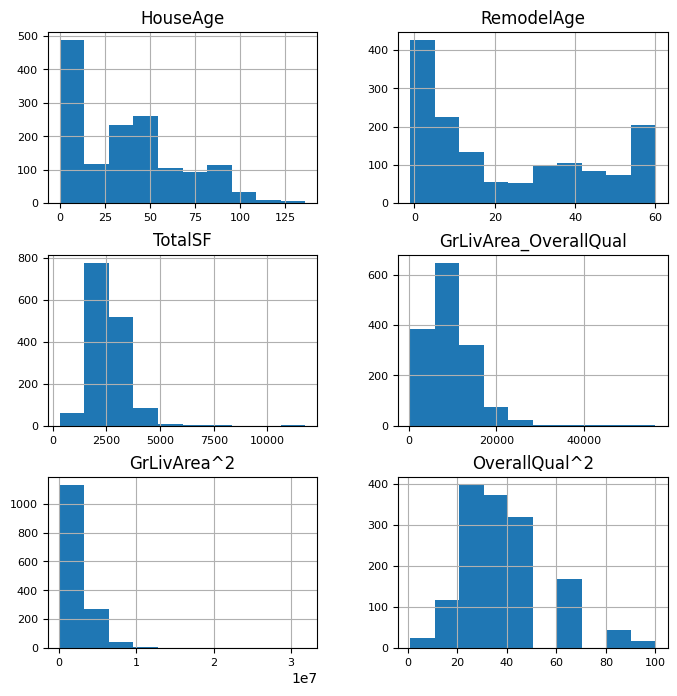

In [17]:
train[new_features].hist(figsize=(8, 8), bins=10, xlabelsize=8, ylabelsize=8);

## Preprocessing

In [18]:
test_ids = test['Id']
X_train = train.drop(columns=['Id', 'SalePrice', 'LogSalePrice'])
y_train = train['LogSalePrice']
X_test = test.drop(columns=['Id'])

Here we drop the extra columns and set the log transformed `SalePrice` as `y`. We also save the `Id` of the test set, which will be used when submitting to Kaggle later. (The standard submission format is shown in `sample_submission.csv`)

In [19]:
ordinal_mappings = {
    "MSSubClass": {
        20: 1, 30: 2, 40: 3, 45: 4, 50: 5,
        60: 6, 70: 7, 75: 8, 80: 9, 85: 10,
        90: 11, 120: 12, 150: 13, 160: 14,
        180: 15, 190: 16
    },
    "LotShape": {"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0},
    "LandSlope": {"Gtl": 2, "Mod": 1, "Sev": 0},
    "ExterQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "ExterCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoBsmt": 0},
    "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoBsmt": 0},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NoBsmt": 0},
    "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NoBsmt": 0},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NoBsmt": 0},
    "HeatingQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "KitchenQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "Functional": {
        "Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4,
        "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0
    },
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoFireplace": 0},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1, "NoGarage": 0},
    "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoGarage": 0},
    "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoGarage": 0},
    "PavedDrive": {"Y": 2, "P": 1, "N": 0},
    "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "NoPool": 0},
    "Fence": {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "NoFence": 0},
    "MiscFeature": {"Gar2": 4, "Shed": 3, "TenC": 2, "Othr": 1, "NoFeature": 0},
    "Alley": {"Grvl": 2, "Pave": 1, "NoAlley": 0},
    "OverallQual": {i: i for i in range(1, 11)},  # 1-10
    "OverallCond": {i: i for i in range(1, 11)}   # 1-10
}

`LabelEncoder` may encode `Ex` as 0 and `Po` as 4, which completely reverses the actual meaning. This is due to `LabelEncoder` assigns values in alphabetical order of categories, which can lead to incorrect assumptions about the order (e.g., A > B > C). Hence, in order to avoid this, we created this `ordinal_mappings`.

In [20]:
for feature in categorical_features:

    # assign type as category
    X_train[feature] = X_train[feature].astype("category")
    X_test[feature] = X_test[feature].astype("category")

    # label encoding
    if feature in ordinal_mappings:
        X_train[feature] = X_train[feature].map(ordinal_mappings[feature])
        X_test[feature] = X_test[feature].map(ordinal_mappings[feature])


original_columns = set(X_train.columns)

# one-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_features, dummy_na=True)
X_test = pd.get_dummies(X_test, columns=nominal_features, dummy_na=True)

# align train and test
X_train, X_test = X_train.align(X_test, join='outer', axis=1)
new_columns = list(set(X_train.columns) - original_columns)

# Fill missing values with 0
X_train[new_columns] = X_train[new_columns].fillna(0)
X_test[new_columns] = X_test[new_columns].fillna(0)

In [21]:
# Define the Iterative Imputer with Random Forest Regressor
iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=100,  # Number of trees
        n_jobs=-1,         # Use all available cores
        random_state=42
    ),
    max_iter=10,
    random_state=42
)

# Fit and transform the train and test
X_train_full = iter_imputer.fit_transform(X_train)
X_test_full = iter_imputer.transform(X_test)

In [22]:
X_train_full = pd.DataFrame(X_train_full, columns=X_train.columns, index=X_train.index)
X_test_full = pd.DataFrame(X_test_full, columns=X_test.columns, index=X_test.index)

In [23]:
scaler = StandardScaler()
X_train_full[numerical_features] = scaler.fit_transform(X_train_full[numerical_features])
X_test_full[numerical_features] = scaler.transform(X_test_full[numerical_features])

Split training data for single validation, `RepeatedKFold` can better evaluate the stability of the model than `train_test_split`, especially for small datasets.

In [24]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
for train_idx, valid_idx in rkf.split(X_train_full, y_train):
    X_train_split, X_valid_split = X_train_full.iloc[train_idx], X_train_full.iloc[valid_idx]
    y_train_split, y_valid_split = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    break  # Only return the first split for simplicity

## Modeling

In [25]:
def save_submission(model, X_test, test_ids, filename='submission.csv'):
    """
    Generate predictions using the provided model and save them to a CSV file.
    
    Parameters:
    - model: Trained model that implements the `predict` method.
    - X_test: ndarray or DataFrame, the test dataset containing the features.
    - test_ids: array-like, unique identifiers for the test samples.
    - filename: str, name of the output submission file. Default is 'submission.csv'.
    
    The function predicts the target variable on the test set, applies an exponential
    transformation to reverse log-transformation (if applied during training), and saves
    the predictions along with the test IDs to a CSV file.
    """
    predictions = np.expm1(model.predict(X_test)) # inverse log-transform
    output_path = os.path.join('data', 'house-prices', 'processed(py)', filename)
    submission = pd.DataFrame({
        'Id': test_ids,
        'SalePrice': predictions
    })
    submission.to_csv(output_path, index=False)
    print(f"Submission file saved to: {output_path}")

### kNN

In [26]:
def train_knn(X_train, y_train):
    # Define the kNN model
    knn = KNeighborsRegressor()

    # Set up hyperparameter grid for tuning
    param_grid = {
        'n_neighbors': range(1, 11), # 1-10
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # Manhattan distance (p=1)
    }                # Euclidean distance (p=2)

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,       # 5-fold cross-validation
        verbose=1,
        n_jobs=-1   # Use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Use the best model to predict on the test set
    return grid_search.best_estimator_

In [27]:
knn_model = train_knn(X_train_split, y_train_split)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Best RMSE: 0.15161816222293886


In [28]:
knn_valid_pred = knn_model.predict(X_valid_split)
knn_valid_rmse = root_mean_squared_error(y_valid_split, knn_valid_pred)
print(f"Validation RMSE (kNN): {knn_valid_rmse}")

Validation RMSE (kNN): 0.17032522997840102


In [29]:
save_submission(knn_model, X_test_full, test_ids, 'knn.csv')

Submission file saved to: data\house-prices\processed(py)\knn.csv


### SVM

In [30]:
def train_svm(X_train, y_train):
    # Define the SVM model
    svm_model = SVR()

    # Set up hyperparameter grid for tuning
    param_grid = {
        'C': [0.1, 1, 10],      # Regularization strength
        'epsilon': [0.01, 0.1], # Epsilon-insensitive loss
        'kernel': ['linear', 'rbf'],       # Kernel types
        'gamma': ['scale', 'auto']
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=svm_model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error', # minimize RMSE
        cv=5,       # 5-fold cross-validation
        verbose=1,
        n_jobs=-1   # use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Use the best model to predict on the test set
    return grid_search.best_estimator_

In [31]:
svm_model = train_svm(X_train_split, y_train_split)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Best RMSE: 0.11875760276477298


In [32]:
svm_valid_pred = svm_model.predict(X_valid_split)
svm_valid_rmse = root_mean_squared_error(y_valid_split, svm_valid_pred)
print(f"Validation RMSE (SVM): {svm_valid_rmse}")

Validation RMSE (SVM): 0.12985131122581856


In [33]:
save_submission(svm_model, X_test_full, test_ids, 'svm.csv')

Submission file saved to: data\house-prices\processed(py)\svm.csv


### Linear Regression

In [34]:
linear_model = LinearRegression()
linear_model.fit(X_train_split, y_train_split)

linear_valid_pred = linear_model.predict(X_valid_split)
linear_valid_rmse = root_mean_squared_error(y_valid_split, linear_valid_pred)
print(f"Validation RMSE (Linear Regression): {linear_valid_rmse}")

Validation RMSE (Linear Regression): 108051429.92181346


In [35]:
save_submission(linear_model, X_test_full, test_ids, 'linear_regression.csv')

Submission file saved to: data\house-prices\processed(py)\linear_regression.csv


C:\Users\ArnoZ\AppData\Local\Temp\ipykernel_30220\1089569966.py:15: RuntimeWarning: overflow encountered in expm1
  predictions = np.expm1(model.predict(X_test)) # inverse log-transform


### Lasso

In [36]:
def train_lasso(X_train, y_train):
    # Define the Lasso model
    lasso = Lasso(max_iter=10000, random_state=42, warm_start=True)

    # Set up hyperparameter grid for tuning
    param_grid = {
        # More fine-grained alpha values for better regularization strength tuning
        'alpha': np.logspace(-4, 2, 30)  # From 0.0001 to 100, 30 evenly spaced values
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=lasso,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error', # Minimize RMSE
        cv=5,      # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters (Lasso):", grid_search.best_params_)
    print("Best RMSE (Lasso):", -grid_search.best_score_)

    # Return the best Ridge model
    return grid_search.best_estimator_

In [37]:
lasso_model = train_lasso(X_train_split, y_train_split)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters (Lasso): {'alpha': np.float64(0.0006723357536499335)}
Best RMSE (Lasso): 0.12663467044628274


In [38]:
lasso_valid_pred = lasso_model.predict(X_valid_split)
lasso_valid_rmse = root_mean_squared_error(y_valid_split, lasso_valid_pred)
print(f"Validation RMSE (Lasso): {lasso_valid_rmse}")

Validation RMSE (Lasso): 0.1338938110142784


In [39]:
save_submission(lasso_model, X_test_full, test_ids, 'lasso.csv')

Submission file saved to: data\house-prices\processed(py)\lasso.csv


### Ridge

In [40]:
def train_ridge(X_train, y_train):
    # Define the Ridge model
    ridge = Ridge(max_iter=10000, random_state=42)

    # Set up hyperparameter grid for tuning
    param_grid = {
        'alpha': np.logspace(-3, 3, 13) # from 0.001 to 1000
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=ridge,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error', # minimize RMSE
        cv=5,      # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Return the best Ridge model
    return grid_search.best_estimator_

In [41]:
ridge_model = train_ridge(X_train_split, y_train_split)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameters: {'alpha': np.float64(3.1622776601683795)}
Best RMSE: 0.1278182559275935


In [42]:
ridge_valid_pred = ridge_model.predict(X_valid_split)
ridge_valid_rmse = root_mean_squared_error(y_valid_split, ridge_valid_pred)
print(f"Validation RMSE (Ridge): {ridge_valid_rmse}")

Validation RMSE (Ridge): 0.12965845670827755


In [43]:
save_submission(ridge_model, X_test_full, test_ids, 'ridge.csv')

Submission file saved to: data\house-prices\processed(py)\ridge.csv


### ElasticNet

In [44]:
def train_elasticnet(X_train, y_train):
    # Define the ElasticNet model
    elasticnet = ElasticNet(max_iter=10000, random_state=42)

    # Set up hyperparameter grid for tuning
    param_grid = {
        'alpha': np.logspace(-4, 2, 13),      # from 0.0001 to 100
        'l1_ratio': np.linspace(0.1, 1.0, 10) # balance between L1 and L2 penalties
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=elasticnet,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # minimize RMSE
        cv=5,      # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Return the best ElasticNet model
    return grid_search.best_estimator_

In [45]:
elasticnet_model = train_elasticnet(X_train_split, y_train_split)

Fitting 5 folds for each of 130 candidates, totalling 650 fits
Best parameters: {'alpha': np.float64(0.001), 'l1_ratio': np.float64(0.4)}
Best RMSE: 0.12578716262255227


In [46]:
elasticnet_valid_pred = elasticnet_model.predict(X_valid_split)
elasticnet_valid_rmse = root_mean_squared_error(y_valid_split, elasticnet_valid_pred)
print(f"Validation RMSE (Ridge): {elasticnet_valid_rmse}")

Validation RMSE (Ridge): 0.12972983276620062


In [47]:
save_submission(elasticnet_model, X_test_full, test_ids, 'elasticnet.csv')

Submission file saved to: data\house-prices\processed(py)\elasticnet.csv


### Decision Tree

In [48]:
def train_tree(X_train, y_train):
    # Define the Decision Tree Regressor
    tree = DecisionTreeRegressor(random_state=42)

    # Set up hyperparameter grid for tuning
    param_grid = {
        'max_depth': [3, 5, 7, 10, 15, None],
        'min_samples_split': [2, 5, 10, 20, 50],
        'min_samples_leaf': [1, 2, 5, 10, 20]
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=tree,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # Minimize RMSE
        cv=5,      # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Use the best model to predict on the test set
    return grid_search.best_estimator_

In [49]:
tree_model = train_tree(X_train_split, y_train_split)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best RMSE: 0.17498563457387445


C:\Users\ArnoZ\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [50]:
tree_valid_pred = ridge_model.predict(X_valid_split)
tree_valid_rmse = root_mean_squared_error(y_valid_split, tree_valid_pred)
print(f"Validation RMSE (Tree): {tree_valid_rmse}")

Validation RMSE (Tree): 0.12965845670827755


In [51]:
save_submission(ridge_model, X_test_full, test_ids, 'decision_tree.csv')

Submission file saved to: data\house-prices\processed(py)\decision_tree.csv


### Random Forest

In [52]:
def train_random_forest(X_train, y_train):
    # Define the Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)

    # Set up hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200, 500],  # Number of trees in the forest
        'max_depth': [10, 20, None],      # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
        'max_features': ['sqrt', 'log2'], # Number of features to consider at every split
        'bootstrap': [True] # Whether bootstrap sampling is used
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # Minimize RMSE
        cv=5,      # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Use the best model to predict on the test set
    return grid_search.best_estimator_

In [53]:
rf_model = train_random_forest(X_train_split, y_train_split)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 0.1352914997113765


In [54]:
rf_valid_pred = rf_model.predict(X_valid_split)
rf_valid_rmse = root_mean_squared_error(y_valid_split, rf_valid_pred)
print(f"Validation RMSE (Random Forest): {rf_valid_rmse}")

Validation RMSE (Random Forest): 0.1484356652188091


In [55]:
save_submission(rf_model, X_test_full, test_ids, 'random_forest.csv')

Submission file saved to: data\house-prices\processed(py)\random_forest.csv


### Bagging

In [56]:
def train_bagging(X_train, y_train):
    # Define the base estimator (weak learner)
    base_estimator = DecisionTreeRegressor(random_state=42)

    # Define the Bagging Regressor
    bagging_model = BaggingRegressor(
        estimator=base_estimator,  # Updated parameter name
        random_state=42
    )

    # Set up hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [10, 50, 100, 200], # Number of base estimators
        'max_samples': [0.5, 0.7, 1.0],     # Fraction of samples to draw
        'max_features': [0.5, 0.7, 1.0],    # Fraction of features to draw
        'estimator__max_depth': [3, 5, 10, None] # Depth of decision trees
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=bagging_model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # Minimize RMSE
        cv=5,  # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Use the best model to predict on the test set
    return grid_search.best_estimator_

In [57]:
bag_model = train_bagging(X_train_split, y_train_split)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'estimator__max_depth': None, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}
Best RMSE: 0.13509426431781696


In [58]:
bag_valid_pred = bag_model.predict(X_valid_split)
bag_valid_rmse = root_mean_squared_error(y_valid_split, bag_valid_pred)
print(f"Validation RMSE (Bagging): {bag_valid_rmse}")

Validation RMSE (Bagging): 0.14377696858693548


In [59]:
save_submission(bag_model, X_test_full, test_ids, 'bagging.csv')

Submission file saved to: data\house-prices\processed(py)\bagging.csv


### XGBoost

In [60]:
def train_xgb(X_train, y_train):
    # Convert to DMatrix for GPU compatibility
    dtrain = DMatrix(X_train, label=y_train)
    
    # Define the XGBoost Regressor
    xgb = XGBRegressor(
        objective='reg:squarederror',  # Regression objective
        random_state=42,
        tree_method = "hist",
        device = "cuda",      # enable gpu
        n_jobs=-1  # Use all available cores
    )

    # Set up hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [100, 300], # Number of boosting rounds
        'learning_rate': [0.05, 0.1, 0.2], # Step size shrinkage
        'max_depth': [3, 5, 7],     # Maximum tree depth
        'subsample': [0.8, 1.0],    # Fraction of samples used for training each tree
        'colsample_bytree': [0.8, 1.0], # Fraction of features used for training each tree
        'gamma': [0, 0.1, 0.2, 0.3],    # Minimum loss reduction required to split
        'reg_alpha': [0, 0.1, 1, 10],   # L1 regularization
        'reg_lambda': [0, 0.1, 1, 10],  # L2 regularization
        'min_child_weight': [1, 3, 5, 10] # Minimum child weight
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=100,
        scoring='neg_root_mean_squared_error', # minimize RMSE
        cv=5,      # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # use all available cores
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", grid_search.best_params_)
    print("Best RMSE:", -grid_search.best_score_)

    # Use the best model to predict on the test set
    return grid_search.best_estimator_

In [61]:
xgb_model = train_xgb(X_train_split, y_train_split)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Best RMSE: 0.12320914496713031


In [62]:
xgb_valid_pred = xgb_model.predict(X_valid_split)
xgb_valid_rmse = root_mean_squared_error(y_valid_split, xgb_valid_pred)
print(f"Validation RMSE (XGBoost): {xgb_valid_rmse}")

Validation RMSE (XGBoost): 0.14073594419026517


C:\Users\ArnoZ\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [00:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [63]:
save_submission(xgb_model, X_test_full, test_ids, 'xgboost.csv')

Submission file saved to: data\house-prices\processed(py)\xgboost.csv


### LightGBM

In [70]:
def train_lgb(X_train, y_train):
    # Define the LightGBM Regressor
    lgb = LGBMRegressor(
        random_state=42,
        boosting_type='gbdt',
        device='gpu',
        n_jobs=-1  # Use all available cores
    )

    # Reduced parameter space
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05],
        'max_depth': [5, 7],
        'num_leaves': [31],  # single value for num_leaves
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'min_child_samples': [10, 20],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [0, 0.1]
    }

    random_search = RandomizedSearchCV(
        estimator=lgb,
        param_distributions=param_dist,
        n_iter=10,  # fewer iterations
        scoring='neg_root_mean_squared_error',
        cv=2,       # fewer folds
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # Fit the grid search to the training data
    random_search.fit(X_train, y_train)

    # Print the best parameters and RMSE
    print("Best parameters:", random_search.best_params_)
    print("Best RMSE:", -random_search.best_score_)

    # Use the best model to predict on the test set
    return random_search.best_estimator_

In [71]:
lgb_model = train_lgb(X_train_split, y_train_split)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
lgb_valid_pred = lgb_model.predict(X_valid_split)
lgb_valid_rmse = root_mean_squared_error(y_valid_split, lgb_valid_pred)
print(f"Validation RMSE (LightGBM): {lgb_valid_rmse}")

In [ ]:
save_submission(lgb_model, X_test_full, test_ids, 'lightgbm.csv')

### Stacking

## Summary


In [ ]:
summary = pd.DataFrame({
    'Models': [
        'kNN', 
        'SVM',
        'Linear Regression',
        'Lasso',
        'Ridge',
        'ElasticNet',
        'Decision Tree',
        'Random Forest',
        'Bagging',
        'XGBoost',
        'LightGBM'
    ],
    'Scores (RMSE)': [
        knn_valid_rmse,
        svm_valid_rmse,
        linear_valid_rmse,
        lasso_valid_rmse,
        ridge_valid_rmse,
        elasticnet_valid_rmse,
        tree_valid_rmse,
        rf_valid_rmse,
        bag_valid_rmse,
        xgb_valid_rmse,
        lgb_valid_rmse
    ]
})

In [ ]:
summary

## References

- Kaggle Competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
- Dataset Description: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data